# Derive cancer and stroma masks in Xenium data

In [3]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

import cv2
import numpy as np
from PIL import Image
import tifffile as tiff
import copy 

sys.path.append(os.path.dirname(os.getcwd()))
from gridgen import get_arrays as ga
from gridgen import contours 
from gridgen import get_masks


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

***Xenium Data***

Xenium data has specific characteristics that are important to be taken into account: 

* Resolution
1 px = 1um

* N Transcripts -> 499 + system and negative controls

* Transcripts are from a custom made panel

The data is part of a Colorectal cancer (CRC) cohort

define files

In [5]:
xenium_path =  '../../xenium_data/HLA/GD_TMA1_S3/fov_filtered'

to_exclude = [
    'TMA1_Selection14_filtered.csv' , # little tumour
    'TMA1_Selection15_filtered.csv', # tonsil
    'TMA1_Selection18_filtered.csv' , # normal
    'TMA1_Selection24_filtered.csv', # tonsl 
    'TMA1_Selection27_filtered.csv', # low quality
    'TMA1_Selection32_filtered.csv', # low quality
    'TMA1_Selection33_filtered.csv', # low quality
             ]
files_tma1 = os.listdir(xenium_path)
# Adding the full path to each file
files_names = [os.path.join(xenium_path, file) for file in files_tma1 if file not in to_exclude]
files_xenium = copy.deepcopy(files_names)
print(len(files_names))

20


Let's open one file to see how it looks like. Negative probes and controls have been removed

In [6]:
file_csv = files_names[0]   # 5
df_total = pd.read_csv(file_csv)
df_total = df_total[['x_location', 'y_location', 'feature_name']]
df_total = df_total.rename(columns={'feature_name': 'target'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]
df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

n genes: 480
shape: 1888, 1801
n hits 3299650


***Define GRIDGEN parameters***

Define GRIDGEN parameters and obtain arrays. 

This part is similar to CosMx. The parameters need ot be adjusted accordingly to the data characteristics. 

Contours designed:

    - Contours for the cancer regions using the cancer transcripts.
    - Contours around the regions that have tissue (emptiness) using all the transcripts available.
    
We will plot the results with the graphics available in GRIDGEN:

    - contours scatter - where each transcript point of that region is blue and the contour is red.
    - conv sum - plot with the convolutional sum image ( densities on each kernel).
    
    
Next we will transform the contours into masks. 
Cancer masks will be equivalent to the cancer contours. Stroma masks will be the total tissue contours without the cancer areas.

Some operations can be done to get smoother masks. In the example below, holes in tumour masks are filled. This is optional. 

we wrap the pipeline in a function and apply it to the full cohort.

In [8]:
# param tum
target_tum = ['EPCAM', 'SMIM22','CLDN3', 'KRT18','LGALS4', 'KRT8', 'ELF3','TSPAN8', 'STMN1', 'CD47', 'MYC', 'LGALS3'] 
density_th_tum = 20    # 50
min_area_th_tum =  700 #1000     check how much is a cell 
kernel_size_tum = 10   # 20

# param empty
density_th_empty = 30
min_area_th_empty = 400 #400
kernel_size_empty = 10

In [14]:
def do_xenium_all(file_csv):
    df_total = pd.read_csv(file_csv)
    df_total = df_total[['x_location', 'y_location', 'feature_name']]
    df_total = df_total.rename(columns={'feature_name': 'target'})
    df_total = df_total[~df_total['target'].str.contains('System|egative')]
    df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
    df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])
    
    n_genes = len(df_total['target'].unique())
    height = int(max(df_total['X'])) + 1
    width = int(max(df_total['Y'])) + 1

    target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
    array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)
    
    # creating subsets 
    df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                         target_list=target_tum, target_col = 'target')
    
    CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
    CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
    CTum.contours_from_sum(density_threshold = density_th_tum,
                           min_area_threshold = min_area_th_tum , directionality = 'higher')
    
    CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
    CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
    CEmpty.contours_from_sum(density_threshold = density_th_empty,
                           min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 
    
       
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    
    CTum.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[0])
    axs[0].set_title('Tum points and tum contours')
    
    CEmpty.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[1])
    axs[1].set_title('total points and contours for empty')
    
    plt.show()
    
    #### obtain masks
    GM = get_masks.GetMasks(image_shape = (height, width))
    
    mask_empty = GM.create_mask(CEmpty.contours)
    mask_tum = GM.create_mask(CTum.contours)
    mask_tum = GM.fill_holes(mask_tum)
    mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
    mask_stroma = GM.filter_binary_mask_by_area(mask_stroma, min_area=700)

    fig, axs = plt.subplots(1, 3, figsize=(26, 8))
    CTum.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                               c_points= 'blue',c_contours= 'red', ax=axs[0])
    axs[0].set_title('Tum points and tum contours')  
    
    
    CEmpty.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                               c_points= 'blue',c_contours= 'red', ax=axs[1])
    axs[1].set_title('total points and contours for empty')  
    plt.subplots_adjust(wspace=0.02)  # Adjust to your preference
    
    GM.plot_masks(masks=[mask_stroma, mask_tum], mask_names=['Stroma', 'Tumour'],
                  background_color=(1, 1, 1), mask_colors={'Stroma': (65, 105, 225), 'Tumour': (255, 165, 0)},
                  path=None, show=False, ax=axs[2])
    axs[2].set_title('Masks')  

    plt.show()


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]2025-06-12 00:32:34,401 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-12 00:32:34,551 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 28
2025-06-12 00:32:34,552 - gridgen.contours.empty - INFO - Initialized GetContour


get_conv_sum took 0.0827 seconds
contours_from_sum took 0.0678 seconds
get_conv_sum took 0.7015 seconds


2025-06-12 00:32:35,822 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 76


contours_from_sum took 0.5694 seconds


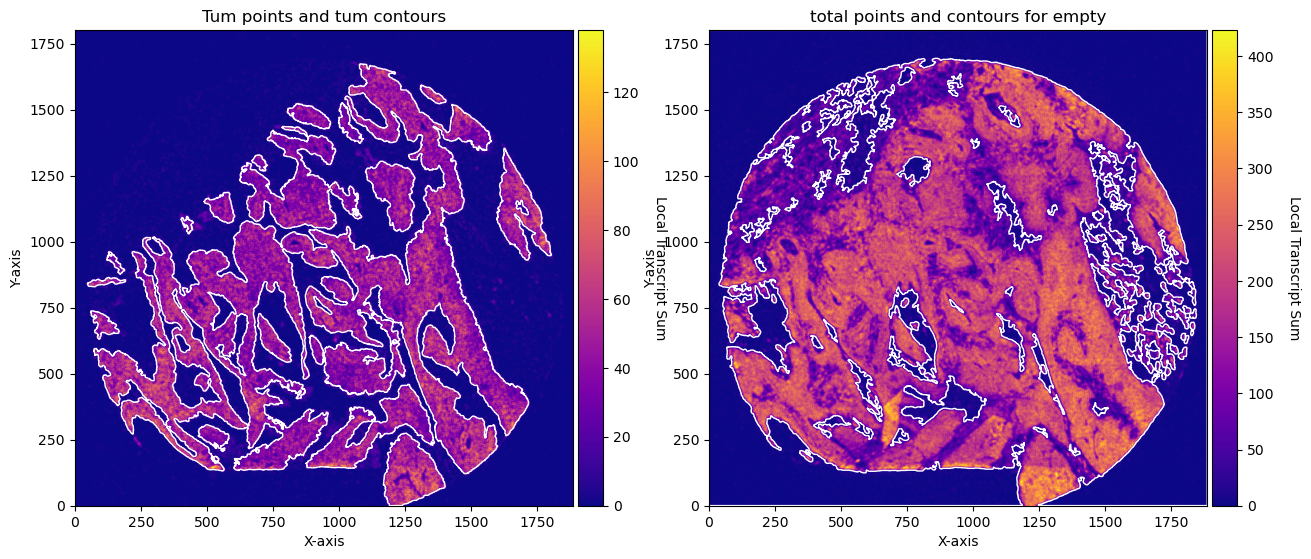

2025-06-12 00:32:36,523 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-12 00:32:36,543 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


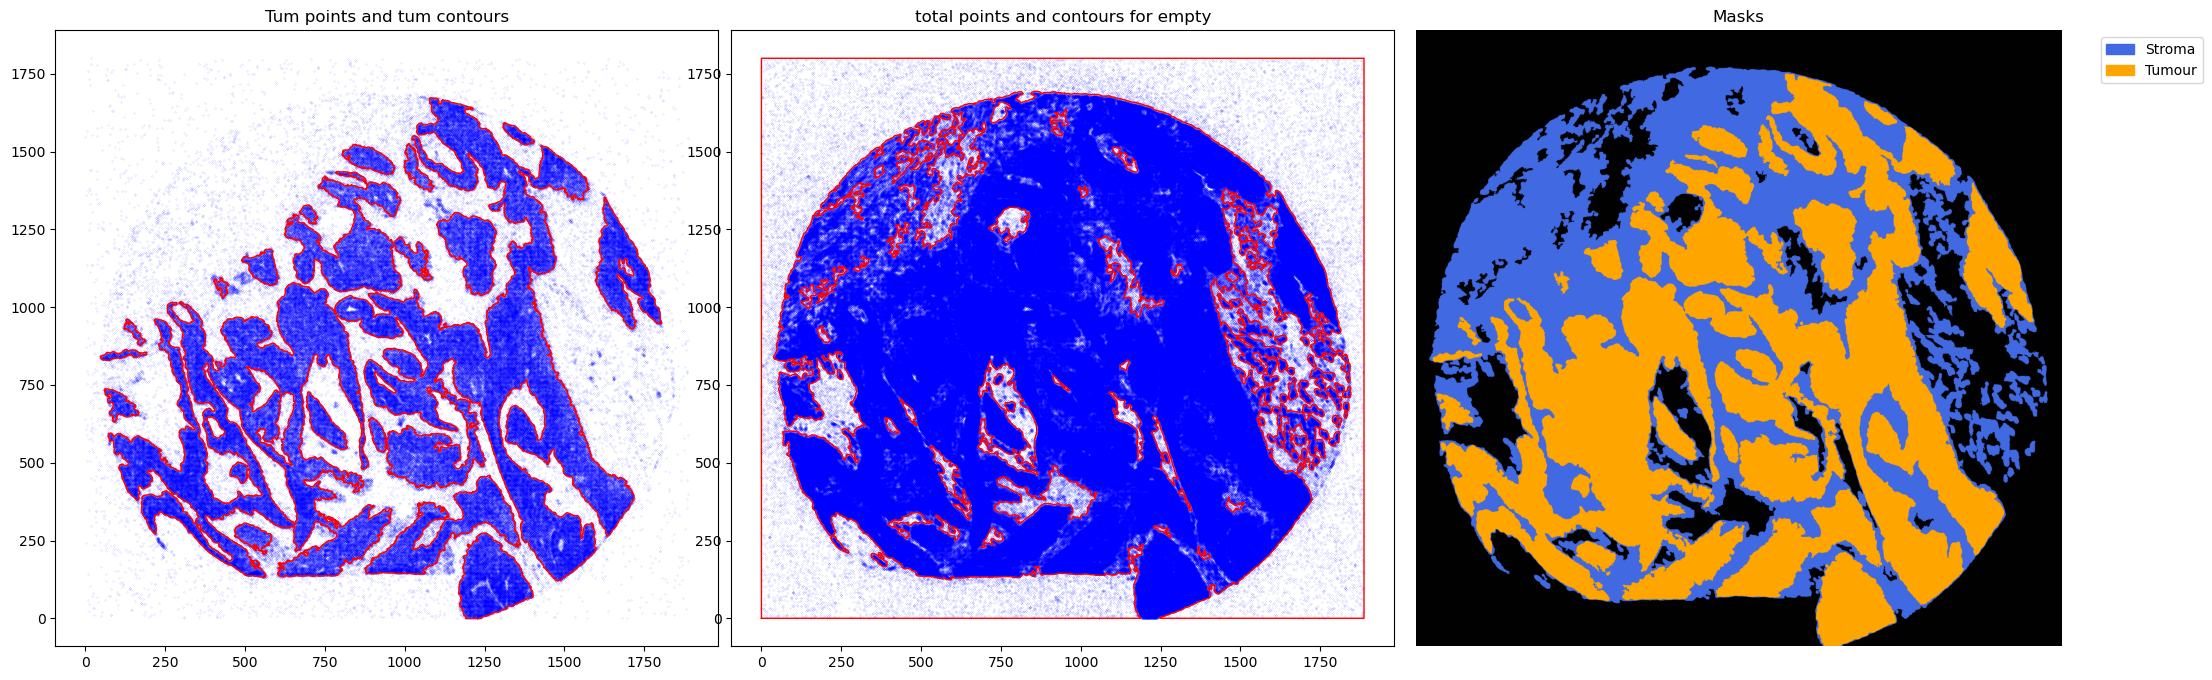

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:08<00:34,  8.50s/it]2025-06-12 00:32:43,676 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-12 00:32:43,824 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 43
2025-06-12 00:32:43,824 - gridgen.contours.empty - INFO - Initialized GetContour


get_conv_sum took 0.0841 seconds
contours_from_sum took 0.0637 seconds
get_conv_sum took 0.5902 seconds


2025-06-12 00:32:45,041 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 16


contours_from_sum took 0.6272 seconds


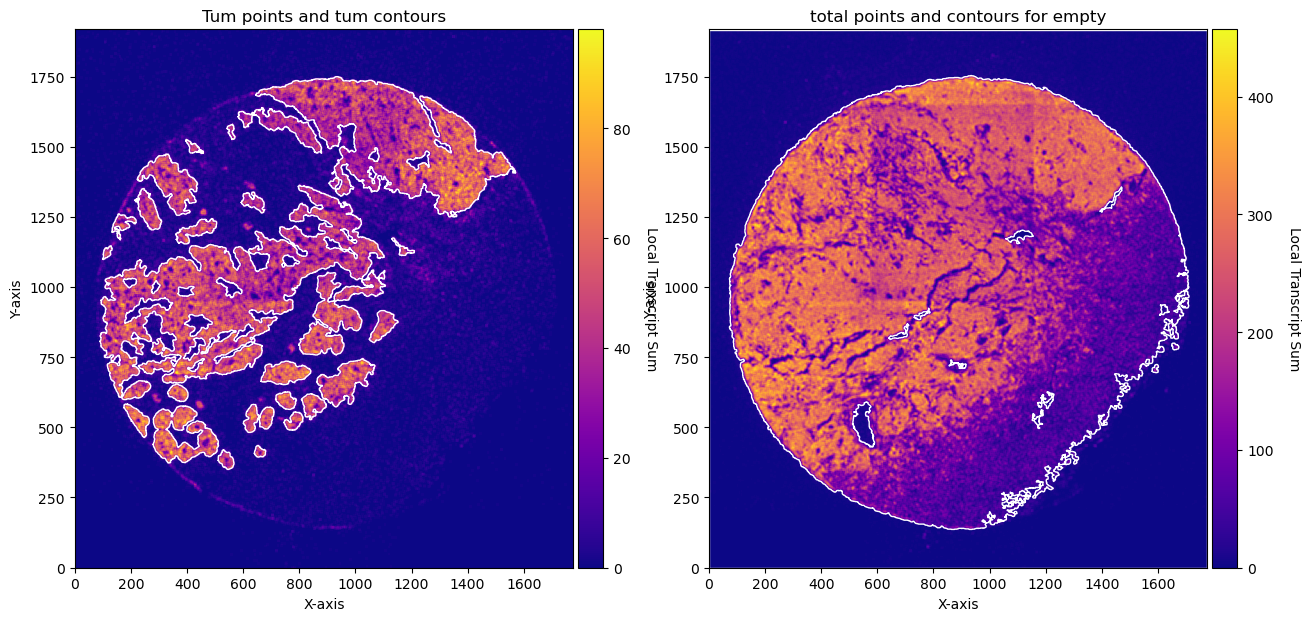

2025-06-12 00:32:45,703 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-12 00:32:45,710 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


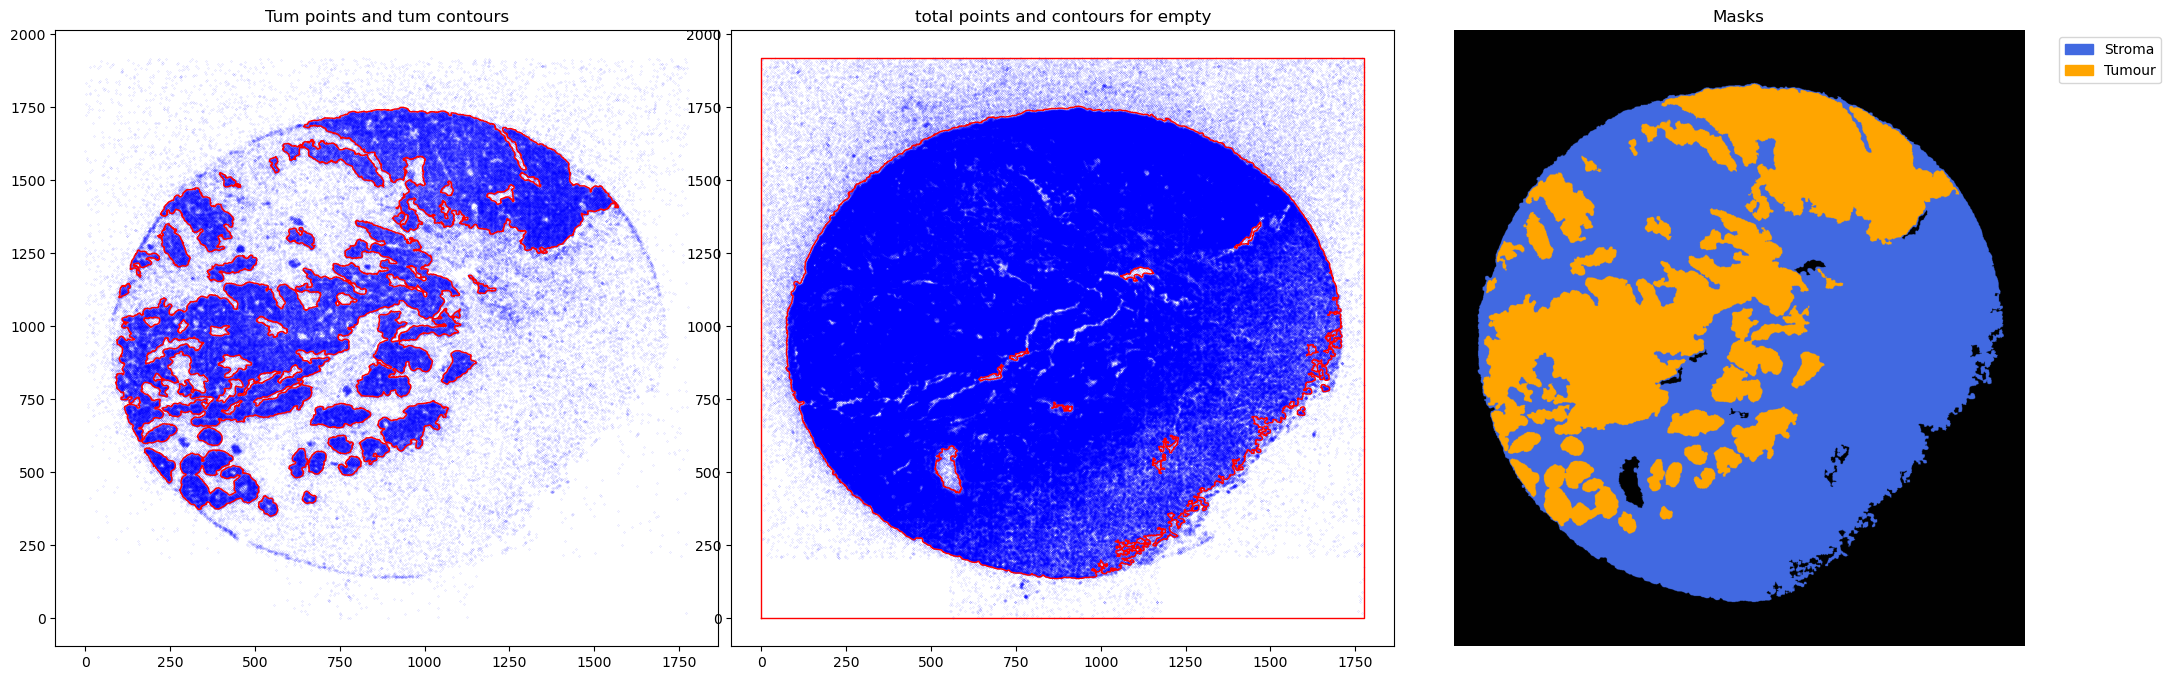

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:17<00:26,  8.85s/it]2025-06-12 00:32:50,609 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-12 00:32:50,723 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 12
2025-06-12 00:32:50,723 - gridgen.contours.empty - INFO - Initialized GetContour


get_conv_sum took 0.0684 seconds
contours_from_sum took 0.0451 seconds
get_conv_sum took 0.4941 seconds


2025-06-12 00:32:51,734 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 66


contours_from_sum took 0.5168 seconds


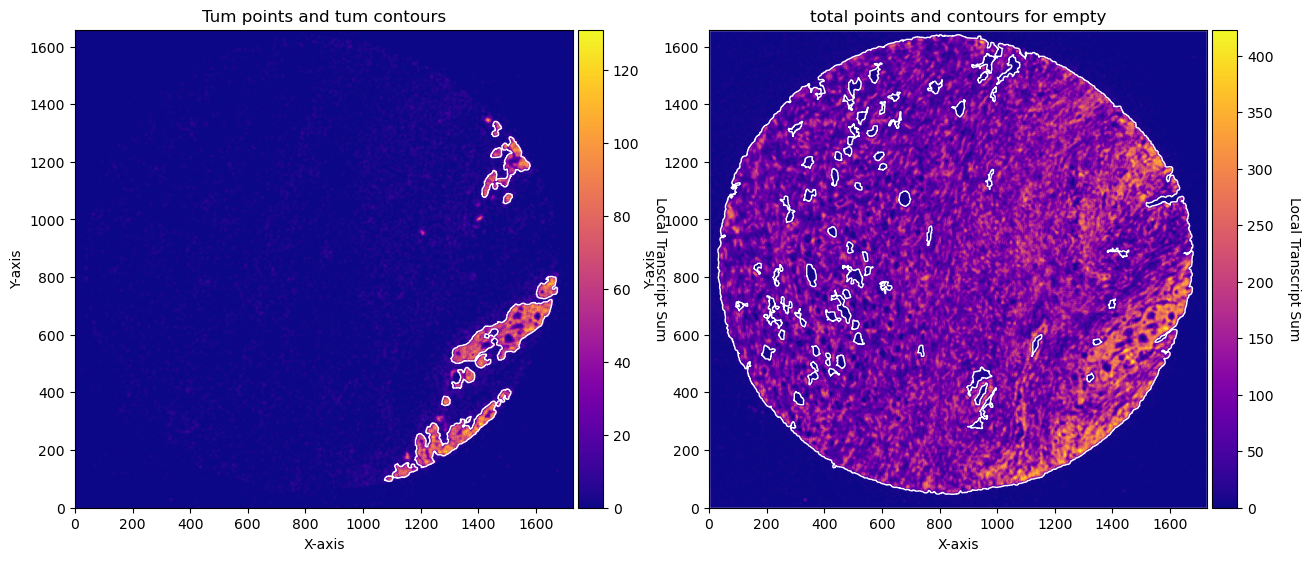

2025-06-12 00:32:52,443 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-12 00:32:52,457 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


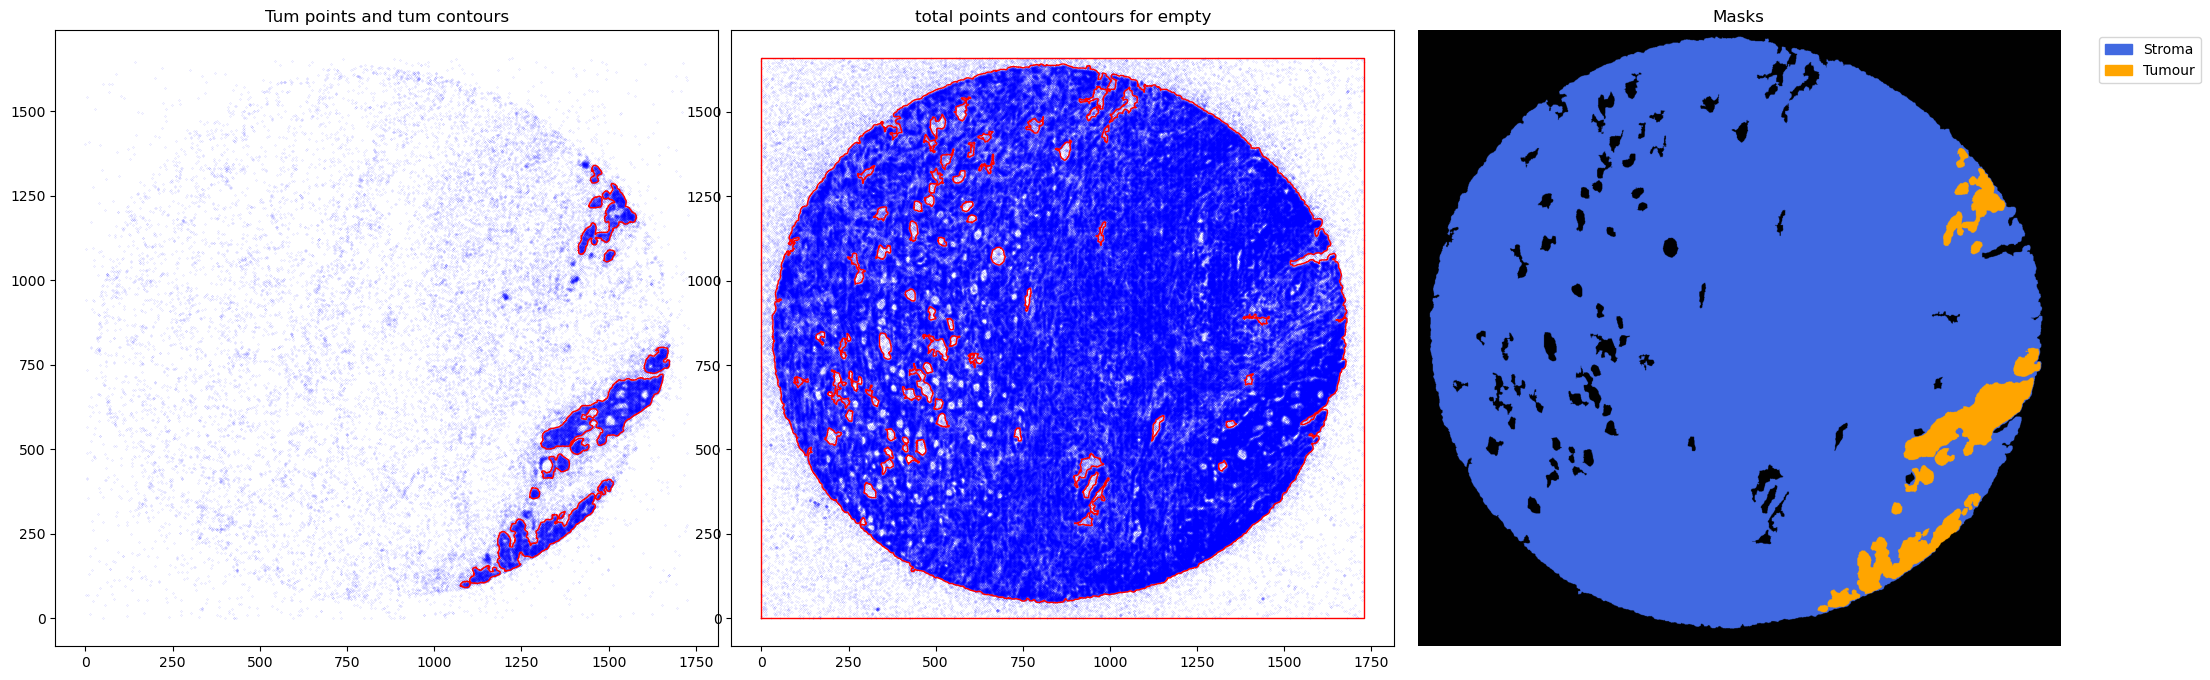

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:24<00:15,  7.79s/it]2025-06-12 00:32:56,421 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-12 00:32:56,527 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 10
2025-06-12 00:32:56,528 - gridgen.contours.empty - INFO - Initialized GetContour


get_conv_sum took 0.0632 seconds
contours_from_sum took 0.0427 seconds
get_conv_sum took 0.5360 seconds


2025-06-12 00:32:57,596 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 8


contours_from_sum took 0.5323 seconds


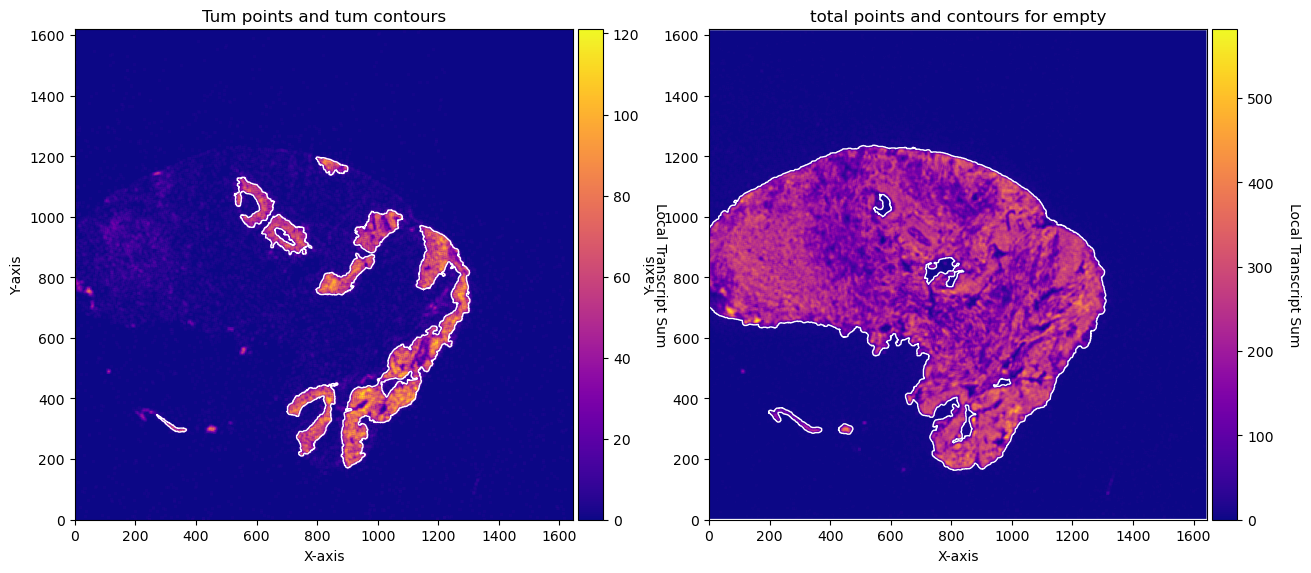

2025-06-12 00:32:58,129 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-12 00:32:58,143 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


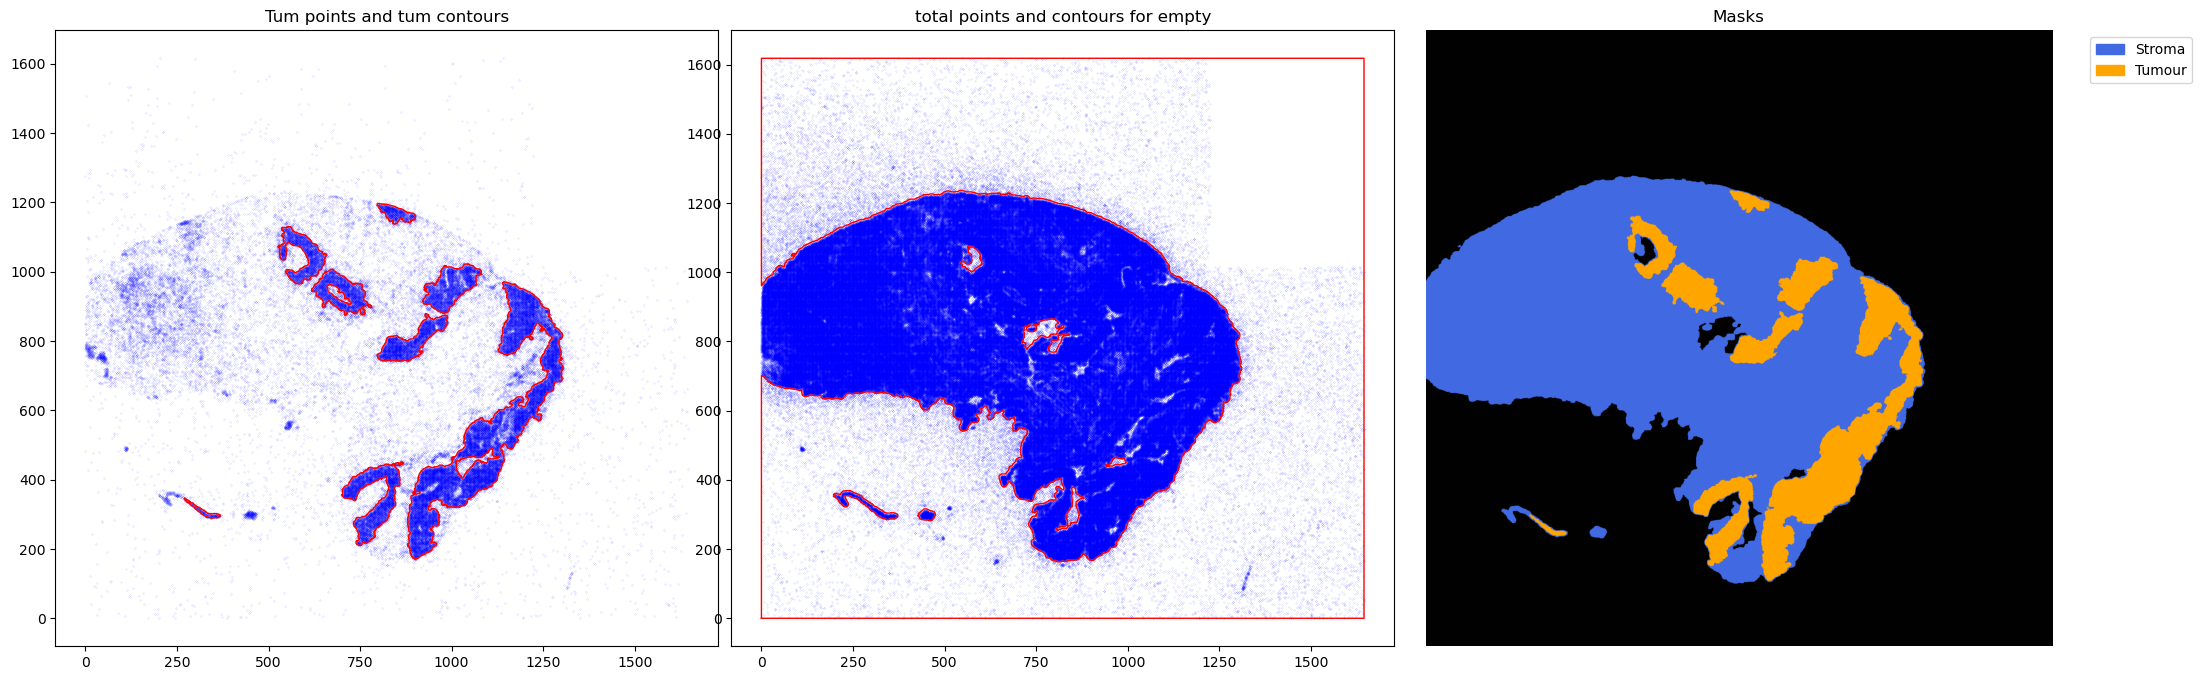

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:29<00:06,  6.91s/it]2025-06-12 00:33:03,213 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-12 00:33:03,349 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 12
2025-06-12 00:33:03,350 - gridgen.contours.empty - INFO - Initialized GetContour


get_conv_sum took 0.0837 seconds
contours_from_sum took 0.0524 seconds
get_conv_sum took 0.5841 seconds


2025-06-12 00:33:04,510 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 35


contours_from_sum took 0.5763 seconds


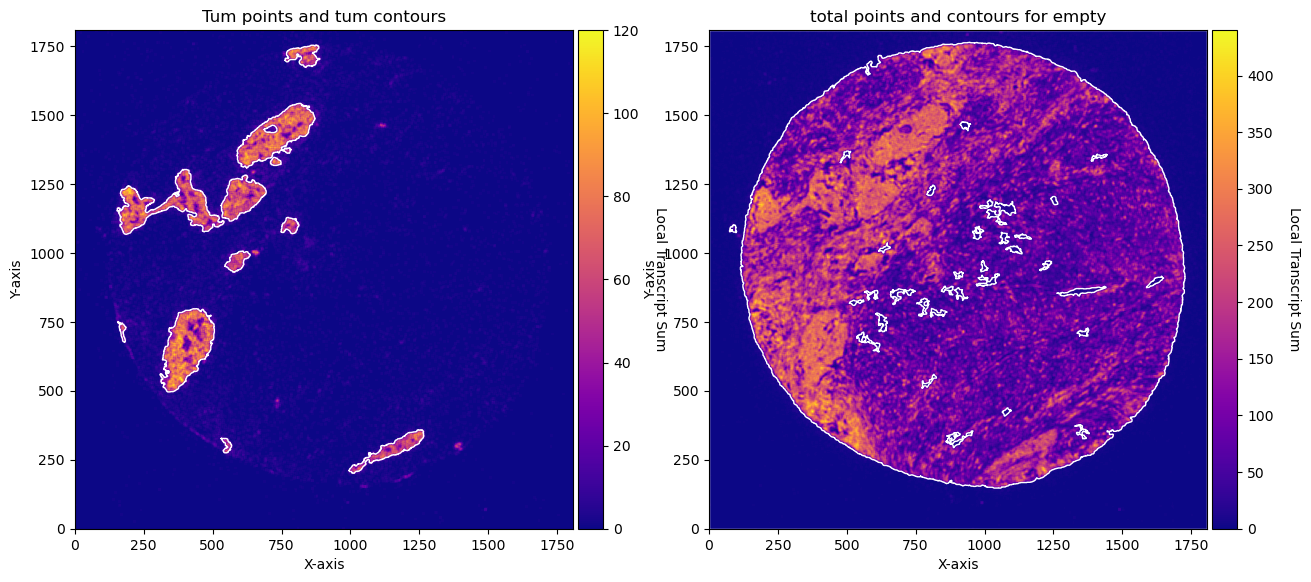

2025-06-12 00:33:05,140 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-12 00:33:05,155 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


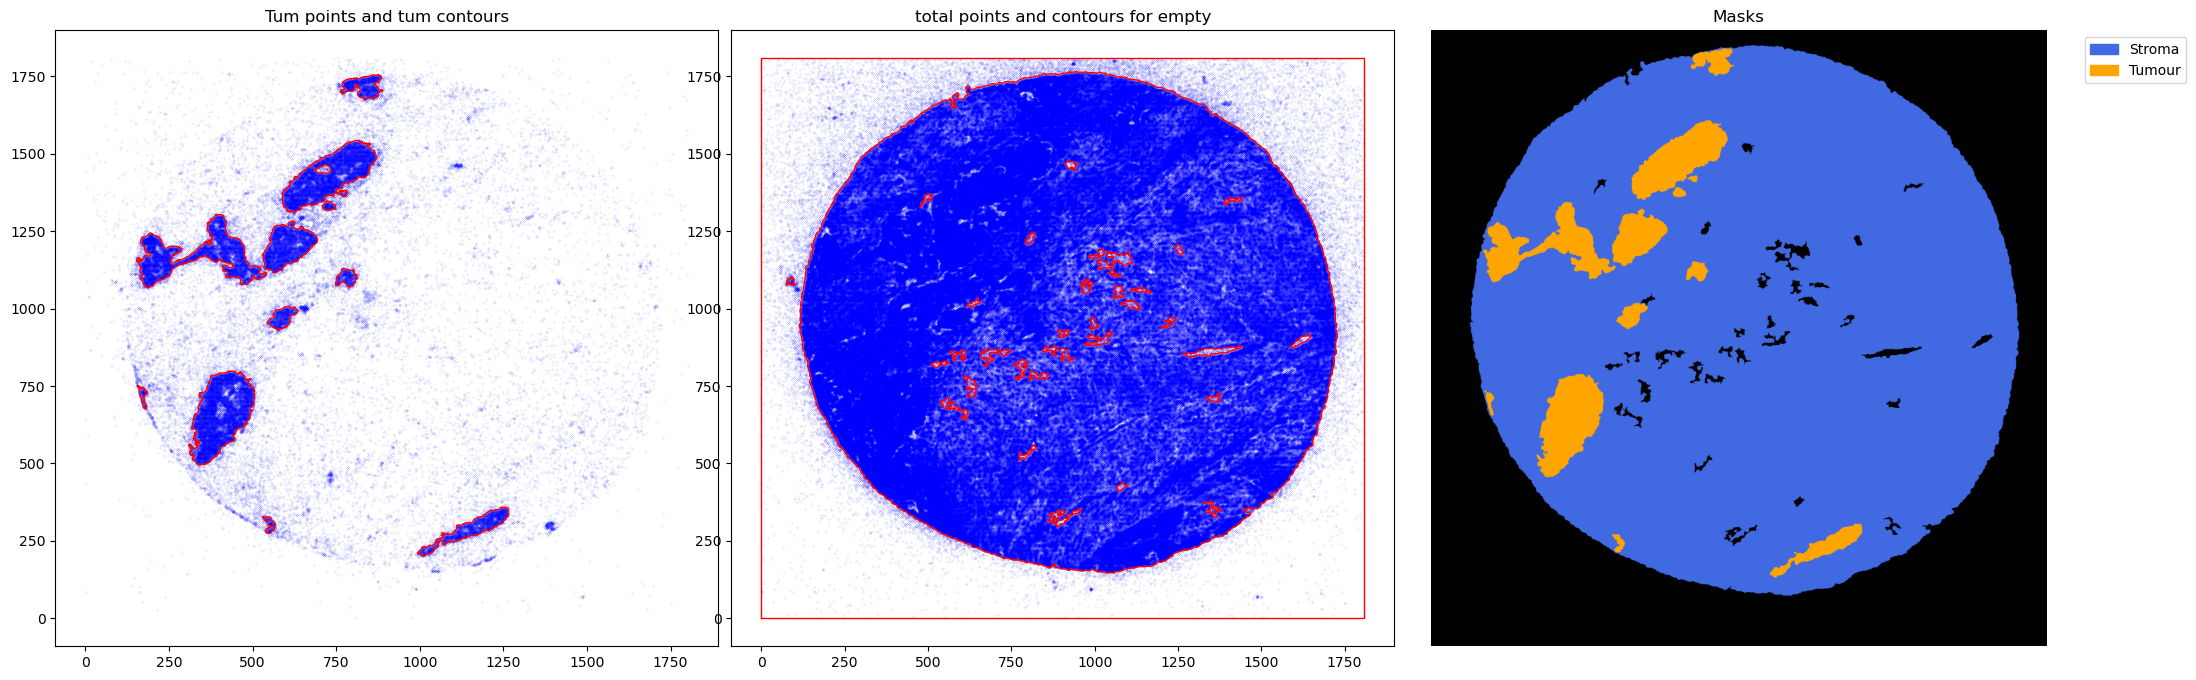

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.37s/it]

CPU times: user 35.6 s, sys: 2.22 s, total: 37.8 s
Wall time: 36.9 s


In [15]:
%%time
for file_csv in tqdm(files_names[:5]):
    GM =  do_xenium_all(file_csv)